In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
class DataConfig(object):
    DATA_DIR = "./SampleData/"
    CSV_FILE = "driving_log.csv"
    IMG_DIR = DATA_DIR+"IMG/"
    MODEL_DIR ="./model/"
    LOG_DIR = "./log/"
    
   
    TRAIN_VAL_RATIO = 0.2
        
    #ORG IMG=352
    IMG_RESHAPE = True
    RESIZE_RATIO = 0.2
    IMG_HEIGHT = 75
    IMG_WIDTH = 320
    IMG_CHANNEL_NUM = 3
    
    EPOCH_NUM = 50
    BATCH_SIZE = 256 #30
    WORKERS_NUM = 4 #2
    
config = DataConfig()

In [3]:
# Loading the csv file
fields = ['center', 'left','right','st_angle']
data_csv = pd.read_csv(config.DATA_DIR+config.CSV_FILE,header=0, usecols=fields)

In [4]:
data_csv.head()

,center,left,right,st_angle
0,center_2016_12_01_13_30_48_287.jpg,left_2016_12_01_13_30_48_287.jpg,right_2016_12_01_13_30_48_287.jpg,0.0
1,center_2016_12_01_13_30_48_404.jpg,left_2016_12_01_13_30_48_404.jpg,right_2016_12_01_13_30_48_404.jpg,0.0
2,center_2016_12_01_13_31_12_937.jpg,left_2016_12_01_13_31_12_937.jpg,right_2016_12_01_13_31_12_937.jpg,0.0
3,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0
4,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0


In [5]:
# Shuffle the dataset
data_csv = data_csv.sample(frac=1).reset_index(drop=True)
data_csv.head()

,center,left,right,st_angle
0,center_2017_12_08_01_13_47_537.jpg,left_2017_12_08_01_13_47_537.jpg,right_2017_12_08_01_13_47_537.jpg,0.000000
1,center_2016_12_01_13_34_34_507.jpg,left_2016_12_01_13_34_34_507.jpg,right_2016_12_01_13_34_34_507.jpg,0.000000
2,center_2017_12_08_01_14_54_667.jpg,left_2017_12_08_01_14_54_667.jpg,right_2017_12_08_01_14_54_667.jpg,-0.096378
3,center_2016_12_01_13_38_39_655.jpg,left_2016_12_01_13_38_39_655.jpg,right_2016_12_01_13_38_39_655.jpg,0.492344
4,center_2017_12_08_01_14_56_994.jpg,left_2017_12_08_01_14_56_994.jpg,right_2017_12_08_01_14_56_994.jpg,0.000000


In [6]:
correction = 0.3
data_csv_img = np.concatenate((data_csv['center'],data_csv['left'],data_csv['right']),axis=0)

center_angle = data_csv["st_angle"].values
right_angle  = center_angle - correction
left_angle = center_angle + correction
data_csv_st = np.concatenate((center_angle,left_angle,right_angle),axis=0)

data_csv_img=data_csv_img.reshape(data_csv_img.shape[0],1)
data_csv_st=data_csv_st.reshape(data_csv_st.shape[0],1)

#print (data_csv_img. shape,data_csv_st.shape)

dataset = np.concatenate ((data_csv_img,data_csv_st), axis=1)
print ("Dataset Shape", dataset.shape)

# Split the set into training and validation
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(dataset, test_size=config.TRAIN_VAL_RATIO)
print ("\nTrain Set Shape", train_set.shape)
print ("Validation Set Shape", val_set.shape)

Dataset Shape (35640, 2)

Train Set Shape (28512, 2)
Validation Set Shape (7128, 2)


(75, 320, 3)


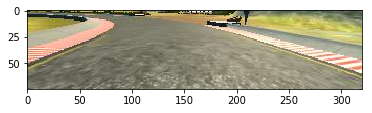

In [7]:
# train_set[0][0]
img = cv2.imread(config.IMG_DIR+str(train_set[0][0]))
#img = cv2.resize(img, None, fx=config.RESIZE_RATIO, fy=config.RESIZE_RATIO)
img = img[60:-25, :, :]#img = img[20:70, :, :]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print(img.shape)

## Data Generator

The following class generates batches dataset on multiple cores in real time to be used for training the deep learning model. 

In [8]:
import keras
from keras.models import Sequential

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, dataset, config=config, shuffle=True):
        
        'initialization'
        self.dim = (config.IMG_HEIGHT, config.IMG_WIDTH)
        self.batch_size = config.BATCH_SIZE
        self.shuffle = shuffle
        self.dataset = dataset
        self.n_channels = config.IMG_CHANNEL_NUM
        self.num_iter = dataset.shape[0] // config.BATCH_SIZE
        self.dataset_size = dataset.shape[0]
        self.on_epoch_end()
    
    def __len__(self):
        
        return self.dataset_size // config.BATCH_SIZE
           
    def on_epoch_end(self):

        self.indexes = np.arange(self.dataset_size)
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        indexes = self.indexes[index * config.BATCH_SIZE:(index+1) * config.BATCH_SIZE]
        
        # find rows
        list_rows = [self.dataset[k] for k in indexes]
        X, y = self.__data_generation(list_rows)
        return X,y
    
    
    def __data_generation(self, list_rows):
        
        X = np.empty((config.BATCH_SIZE, config.IMG_HEIGHT,config.IMG_WIDTH, config.IMG_CHANNEL_NUM), np.float)
        y = np.empty((config.BATCH_SIZE,1), np.float)
        
        for i, row in enumerate (list_rows):
            #print(i, row, "\n")
            img = cv2.imread (config.IMG_DIR+ str(row[0]))
            #print (img.shape)
            
            if config.IMG_RESHAPE is True:
                #img = cv2.resize(img, None, fx=config.RESIZE_RATIO, fy=config.RESIZE_RATIO)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img[60:-25, :, :]          

            X[i,] = img.reshape(img.shape[0],img.shape[1],config.IMG_CHANNEL_NUM)
            
            y[i] = float(row[1])
            
        return X,y 

        # test = DataGenerator(val_set)

Using TensorFlow backend.


In [9]:
from keras.layers import Dense, Conv2D, Dropout, Flatten, Lambda, ELU, Activation, MaxPooling2D,BatchNormalization
from keras import optimizers


class CreateModel(object):
    def model_01(self):
        
        row = config.IMG_HEIGHT
        col = config.IMG_WIDTH
        ch = config.IMG_CHANNEL_NUM
        
        model = Sequential(name="model_01")
        model.add(Lambda(lambda x: (x/255.0)-0.5,input_shape=(row, col, ch )))
        
        model.add(Conv2D(48, (7, 7), strides=(2, 2), padding="same"))
        
        model.add(Activation('relu'))
        model.add(Conv2D(50, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation('relu'))
        model.add(Conv2D(50, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Flatten())

        # Added a Dropout layer to help reduce overfitting. 
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(100))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('relu'))
        model.add(Dense(20))
        model.add(Activation('relu'))
        model.add(Dense(1))
        
        
        adam_custom = optimizers.Adam() #lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-8
        model.compile(optimizer=adam_custom, loss="mse")
        
        #model.compile(optimizer="adam", loss="mse")

        print('model_01 is created and compiled..')
        print (model.summary())
        return model
    
    def nvidia(self):
        row = config.IMG_HEIGHT
        col = config.IMG_WIDTH
        ch = config.IMG_CHANNEL_NUM
        
        model = Sequential(name="model_02")
        model.add(Lambda(lambda x: (x/255.0)-0.5,input_shape=(row, col, ch )))
        
        model.add(Conv2D(24, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation('elu'))
        model.add(Conv2D(36, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation('elu'))
        model.add(Conv2D(48, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation('elu'))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation('elu'))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Dropout(0.5))
        model.add(Flatten())

        # Added a Dropout layer to help reduce overfitting. 
        
        model.add(Dense(100))
        model.add(Activation('elu'))
        model.add(Dense(50))
        model.add(Activation('elu'))
        model.add(Dense(10))
        model.add(Activation('elu'))
        model.add(Dense(1))
        
        adam_custom = optimizers.Adadelta() #lr=0.00001,beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        model.compile(optimizer=adam_custom, loss="mse")
        
        #model.compile(optimizer="adam", loss="mse")

        print('model_02 is created and compiled..')
        print (model.summary())
        return model
    
    
    


In [10]:
model = CreateModel().nvidia()

model_02 is created and compiled..
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 160, 24)       1824      
_________________________________________________________________
activation_1 (Activation)    (None, 38, 160, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 80, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 19, 80, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 40, 48)        43248     
_________________________________________________________________
activation_3 (Activation)    (None, 10, 4

In [11]:
# save Model with the min 'val_loss'
from keras.callbacks import ModelCheckpoint,TensorBoard
print ("Model save path:",config.MODEL_DIR+"model.h5" )

checkpoint = ModelCheckpoint(config.MODEL_DIR+"{epoch:02d}-{val_loss:.5f}.h5", monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

print ("Log dir: "+ config.LOG_DIR)

# TensorBoard
vis = TensorBoard(log_dir=config.LOG_DIR,
                      batch_size = config.BATCH_SIZE,
                      write_graph=False,
                      write_images=False)


callback_list = [checkpoint, vis]

Model save path: ./model/model.h5
Log dir: ./log/


In [12]:
train_generator = DataGenerator(train_set)
valid_generator = DataGenerator(val_set)

In [13]:
model.fit_generator(generator=train_generator,
                    validation_data = valid_generator,
                    callbacks=callback_list,
                    epochs=config. EPOCH_NUM,
                    use_multiprocessing = True,
                    workers = config.WORKERS_NUM
         )

Epoch 1/50
110/111 [============================>.] - ETA: 0s - loss: 0.0541Epoch 1/50
Epoch 1/50
111/111 [==============================] - 43s 389ms/step - loss: 0.0539 - val_loss: 0.0370

Epoch 00001: val_loss improved from inf to 0.03701, saving model to ./model/01-0.03701.h5
Epoch 2/50
110/111 [============================>.] - ETA: 0s - loss: 0.0374
Epoch 00001: val_loss improved from inf to 0.03701, saving model to ./model/01-0.03701.h5
111/111 [==============================] - 41s 370ms/step - loss: 0.0375 - val_loss: 0.0356

Epoch 00002: val_loss improved from 0.03701 to 0.03563, saving model to ./model/02-0.03563.h5
Epoch 3/50
111/111 [==============================] - 41s 370ms/step - loss: 0.0346 - val_loss: 0.0376

Epoch 00003: val_loss did not improve from 0.03563
Epoch 4/50
111/111 [==============================] - 41s 372ms/step - loss: 0.0316 - val_loss: 0.0294

Epoch 00004: val_loss improved from 0.03563 to 0.02937, saving model to ./model/04-0.02937.h5
Epoch 5/50
1


Epoch 00036: val_loss did not improve from 0.01330
Epoch 37/50
111/111 [==============================] - 39s 352ms/step - loss: 0.0095 - val_loss: 0.0134

Epoch 00037: val_loss did not improve from 0.01330
Epoch 38/50
110/111 [============================>.] - ETA: 0s - loss: 0.0093
Epoch 00037: val_loss did not improve from 0.01330
Epoch 38/50
111/111 [==============================] - 40s 357ms/step - loss: 0.0093 - val_loss: 0.0135

Epoch 00038: val_loss did not improve from 0.01330
Epoch 39/50
111/111 [==============================] - 40s 357ms/step - loss: 0.0091 - val_loss: 0.0136

Epoch 00039: val_loss did not improve from 0.01330
Epoch 40/50
111/111 [==============================] - 40s 361ms/step - loss: 0.0091 - val_loss: 0.0131

Epoch 00040: val_loss improved from 0.01330 to 0.01313, saving model to ./model/40-0.01313.h5
Epoch 41/50
111/111 [==============================] - 39s 352ms/step - loss: 0.0090 - val_loss: 0.0133

Epoch 00041: val_loss did not improve from 0.01